Хамеджанов Алмаз 11-702, Каюмов Булат 11-702, Маннанова Гульназ 11-707

Набор данных ORGANICS содержит 13 переменных и более 22000 наблюдений.

Описание: В супермаркете действует программа лояльности клиентов. В качестве плана для первоначального стимулирования покупок всем участникам программы лояльности были предложены купоны на покупку органических продуктов. Затем были собраны данные о том, купили ли эти клиенты какой-либо из органических продуктов.

Цель: Исследовать модель для предсказания влияний купонов на покупку товара.

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import pydot
import numpy as np

from sklearn.tree import export_graphviz
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import roc_auc_score, roc_curve, mean_squared_error, r2_score

from imblearn.over_sampling import (RandomOverSampler,
                                    SMOTE,
                                    ADASYN)
from imblearn.under_sampling import NearMiss

plt.style.use('ggplot')

class bcolors:
    HEADER = '\033[95m'
    OKBLUE = '\033[94m'
    OKGREEN = '\033[92m'
    WARNING = '\033[93m'
    FAIL = '\033[91m'
    ENDC = '\033[0m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'

# подключаем данные
dataframe=pd.read_csv("ORGANICS.csv")

Информация о данных:
ID - идентификатор клиента-участника программы лояльности
DemAffl - уровень доходов от 1 до 30
DemAge - возраст
DemCluster - тип района, в котором проживает клиент
DemClusterGroup - область проживания
DemGender - M = мужской, F = женский, U = неизвестный
DemReg - географический район
DemTVReg - регион телевещания
PromClass - Статус программы лояльности: tin - оловянный, silver - серебряный, gold - золотой, platinum - плтинум
PromSpend - общая потраченная сумма
PromTime - срок участия в программе лояльности
TargetBuy - приобретен ли продукт: 0 == Нет, 1 == Да
TargetAmt - количество приобритенных продуктов

In [2]:
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22223 entries, 0 to 22222
Data columns (total 13 columns):
ID                 22223 non-null int64
DemAffl            21138 non-null float64
DemAge             20715 non-null float64
DemCluster         21549 non-null float64
DemClusterGroup    21549 non-null object
DemGender          19711 non-null object
DemReg             21758 non-null object
DemTVReg           21758 non-null object
PromClass          22223 non-null object
PromSpend          22223 non-null float64
PromTime           21942 non-null float64
TargetBuy          22223 non-null int64
TargetAmt          22223 non-null int64
dtypes: float64(5), int64(3), object(5)
memory usage: 2.2+ MB


Заполняем значения null: берем моду по числовому значению, и в пусты строки добавляем средние значения. 
Удаляем столбцы 'TargetAmt', 'DemClusterGroup', т.к. в дальнейшем для обучения они нам не пригодятся

In [3]:
dataframe = dataframe.fillna(dataframe.mode().iloc[0])
dataframe = dataframe.drop(columns=['TargetAmt', 'DemClusterGroup'])
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22223 entries, 0 to 22222
Data columns (total 11 columns):
ID            22223 non-null int64
DemAffl       22223 non-null float64
DemAge        22223 non-null float64
DemCluster    22223 non-null float64
DemGender     22223 non-null object
DemReg        22223 non-null object
DemTVReg      22223 non-null object
PromClass     22223 non-null object
PromSpend     22223 non-null float64
PromTime      22223 non-null float64
TargetBuy     22223 non-null int64
dtypes: float64(5), int64(2), object(4)
memory usage: 1.9+ MB


Получаем маску для категориальных признаков. Категориальный признак – это признак, значения которого обозначают принадлежность объекта к какой-то категории. В нашем случае - это, например, регион телевещания или географический район.

In [4]:
categorical_feature_mask = dataframe.dtypes == object
categorical_columns = dataframe.columns[categorical_feature_mask].tolist()

Используем кодировщик LabelEncoding для преобразования категориальных символов, который каждой категории сопоставляет некоторое целое число (собственно, номер категории).

In [5]:
le = LabelEncoder()
dataframe[categorical_columns] = dataframe[categorical_columns].apply(lambda col: le.fit_transform(col))

Смотрим корреляционную зависимость, т.е. статистическая взаимосвязь двух или более случайных величин (либо величин, которые можно с некоторой допустимой степенью точности считать таковыми). При этом изменения значений одной или нескольких из этих величин сопутствуют систематическому изменению значений другой или других величин.

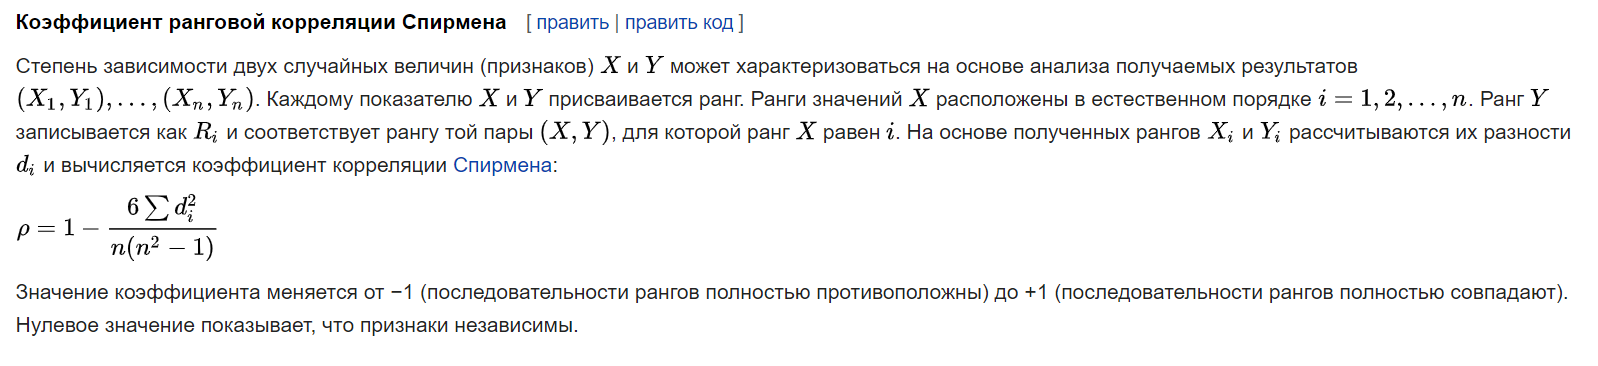

Берем значение корреляции по модулю, т.к. рассматривается стандартный коэффициент корреляции Спирмена и выбираем признаки сo значением корреляции >=0,2

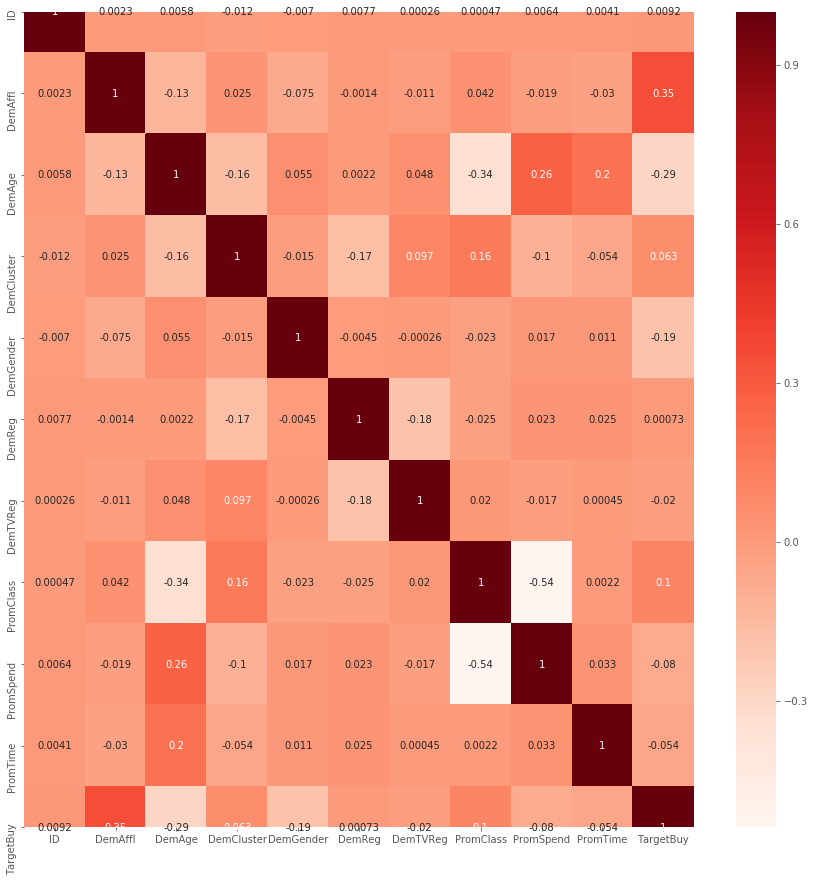

DemAffl    0.349522
DemAge     0.291768
Name: TargetBuy, dtype: float64


In [6]:
plt.figure(figsize=(15, 15))
correlation_matrix = dataframe.corr()  
sns.heatmap(correlation_matrix, annot=True, cmap=plt.cm.Reds)
plt.show()

cor_target = abs(correlation_matrix['TargetBuy'])
relevant_features = cor_target[cor_target >= 0.2].drop('TargetBuy')
print(relevant_features)

Коэффициент корреляции Пирсона показывает, что есть зависимость между уровнем доходов / возрастом / полом и TargetBuy, а переменные DemReg, DemTVReg практически не влияют на TargetBuy. Но стоит отметить, что отсутствие корреляции между двумя величинами ещё не значит, что между ними нет никакой связи. Например, зависимость может иметь сложный нелинейный характер, который корреляция не выявляет.

In [7]:
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22223 entries, 0 to 22222
Data columns (total 11 columns):
ID            22223 non-null int64
DemAffl       22223 non-null float64
DemAge        22223 non-null float64
DemCluster    22223 non-null float64
DemGender     22223 non-null int32
DemReg        22223 non-null int32
DemTVReg      22223 non-null int32
PromClass     22223 non-null int32
PromSpend     22223 non-null float64
PromTime      22223 non-null float64
TargetBuy     22223 non-null int64
dtypes: float64(5), int32(4), int64(2)
memory usage: 1.5 MB


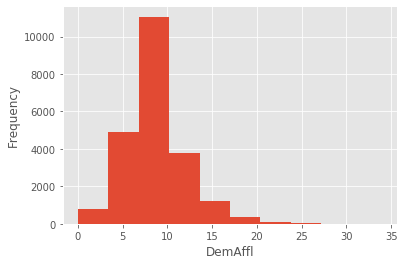

Уровень доходов


In [8]:
ax = dataframe['DemAffl'].plot(kind='hist')
ax.set_xlabel('DemAffl')
plt.show()
print("Уровень доходов")

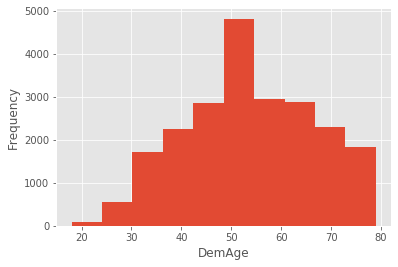

Возраст


In [9]:
ax = dataframe['DemAge'].plot(kind='hist')
ax.set_xlabel('DemAge')
plt.show()
print("Возраст")

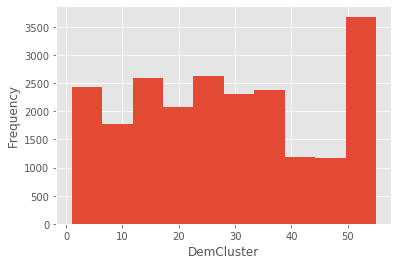

Тип района, в котором проживает клиент


In [10]:
ax = dataframe['DemCluster'].plot(kind='hist')
ax.set_xlabel('DemCluster')
plt.show()
print("Тип района, в котором проживает клиент")

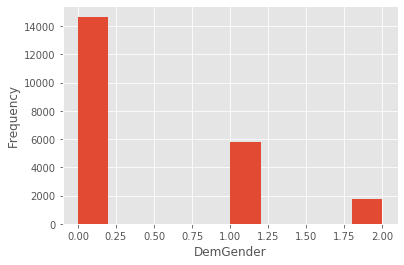

Пол


In [11]:
ax = dataframe['DemGender'].plot(kind='hist')
ax.set_xlabel('DemGender')
plt.show()
print("Пол")

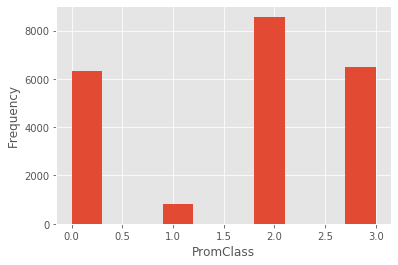

Статус программы лояльности


In [12]:
ax = dataframe['PromClass'].plot(kind='hist')
ax.set_xlabel('PromClass')
plt.show()
print("Статус программы лояльности")

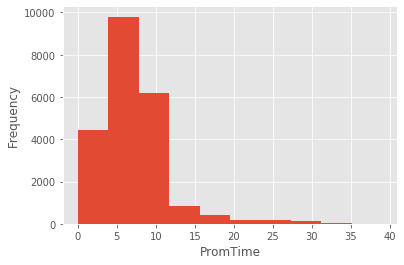

Срок участия в программе лояльности


In [13]:
ax = dataframe['PromTime'].plot(kind='hist')
ax.set_xlabel('PromTime')
plt.show()
print("Срок участия в программе лояльности")

Смотрим балансировку выборки по переменной TargetBuy. Если органический продукт приобретен - 1, если нет - 0. Вычисляем процент купивших органические продукты.

Число купивших - 5505
Число не купивших - 16718


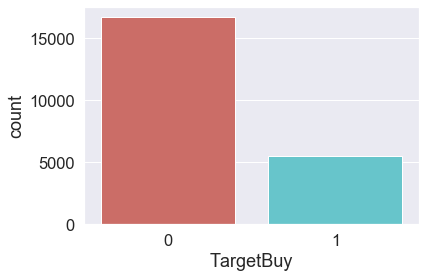

In [14]:
print("Число купивших -", len(dataframe[dataframe['TargetBuy'] == 1]))
print("Число не купивших -", len(dataframe[dataframe['TargetBuy'] == 0]))

sns.set(font_scale=1.5)
count_plt = sns.countplot(x='TargetBuy', data=dataframe, palette='hls')
plt.show()

In [15]:
Count_Buy = len(dataframe[dataframe["TargetBuy"]==1]) 
Count_Not_Buy = len(dataframe[dataframe["TargetBuy"]==0])
Perc_Of_Buy = Count_Buy/(Count_Buy+Count_Not_Buy)
print("Процент купивших:",Perc_Of_Buy*100)
Perc_Of_Not_Buy = Count_Not_Buy/(Count_Buy+Count_Not_Buy)
print("Процент не купивших:",Perc_Of_Not_Buy*100)

Процент купивших: 24.771632992845248
Процент не купивших: 75.22836700715474


Таким образом, делаем вывод, что наша выборка несбалансирована. Процент некупивших намного превосходит число купивших. Назовем класс купивших – миноритарным (т.к. это класс меньшинств), а класс некупивших – мажоритарным). Построенный на таких наборах данных классификатор может оказаться абсолютно неэффективным.

Одним из подходов для решения указанной проблемы является применение различных стратегий сэмплинга, которые можно разделить на две группы: случайные и специальные.
Восстановление баланса классов может проходить двумя путями. В первом случае удаляют некоторое количество примеров мажоритарного класса (undersampling), во втором – увеличивают количество примеров миноритарного (oversampling).

Преимущество oversampling состоит в том, что никакая информация из исходного обучающего набора не теряется, поскольку все наблюдения из классов меньшинства и большинства сохраняются. С другой стороны, он склонен к переоснащению.

Преимущества:

•	Без потери информации

•	Смягчение перегрузки из-за передискретизации.

Недостатки:

•	Переобучения

Undersampling, в отличие от oversampling, направлен на уменьшение количества основных выборок, чтобы сбалансировать распределение классов. Так как он удаляет наблюдения из исходного набора данных, он может отбросить полезную информацию.

Преимущества:

•	Время выполнения может быть улучшено за счет уменьшения количества обучающих данных.

•	Помогает в решении проблем с памятью

Недостатки:

•	Потеря важной информации

Случайная избыточная выборка - oversampling_df_by_Minority

Принцип: Random oversampling включает в себя дополнение обучающих данных несколькими копиями некоторых миноритарных классов. Oversampling можно выполнять несколько раз (2x, 3x, 5x, 10x и т. Д.). Это один из самых ранних предложенных методов, который также доказал свою надежность. Вместо дублирования каждой выборки в миноритарным классе, некоторые из них могут быть случайно выбраны с заменой.

In [16]:
def oversampling_df_by_Minority(df):
    # balance our df by Minority sample
    df_majority = df[df['TargetBuy'] == 0]
    df_minority = df[df['TargetBuy'] == 1]

    df_minority_oversampled = resample(df_minority,
                                       replace=True,
                                       n_samples=len(df_majority),
                                       random_state=4
                                       )

    df_oversampled = pd.concat([df_majority, df_minority_oversampled])
    print(df_oversampled['TargetBuy'].value_counts())

    X_res, y_res = making_X_y_from_df(df_oversampled)

    return X_res, y_res

Алгоритм SMOTE - oversampling_df_by_SMOTE

Эта стратегия основана на идее генерации некоторого количества искусственных примеров, которые были бы «похожи» на имеющиеся в миноритарном классе, но при этом не дублировали их. Для создания новой записи находят разность d=Xb–Xad=Xb–Xa, где Xa,XbXa,Xb – векторы признаков «соседних» примеров aa и bb из миноритарного класса. Их находят, используя алгоритм ближайшего соседа (KNN). В данном случае необходимо и достаточно для примера bb получить набор из kk соседей, из которого в дальнейшем будет выбрана запись bb. Остальные шаги алгоритма KNN не требуются.
Алгоритм SMOTE позволяет задавать количество записей, которое необходимо искусственно сгенерировать. Степень сходства примеров aa и bb можно регулировать путем изменения значения kk (числа ближайших соседей).
Данный подход имеет недостаток в том, что «вслепую» увеличивает плотность примерами в области слабо представленного класса. В случае, если миноритарные примеры равномерно распределены среди мажоритарных и имеют низкую плотность, алгоритм SMOTE только сильнее перемешает классы.

In [17]:
def oversampling_df_by_SMOTE(df):
    X, y = making_X_y_from_df(df)

    print_res_sampling(X, y, 'Before', 'Oversampling')

    sm = SMOTE(random_state = 0)
    X_res, y_res = sm.fit_sample(X, y.ravel())

    print_res_sampling(X_res, y_res, 'After', 'Oversampling')

    return X_res, y_res

Алгоритм ADASYN - oversampling_df_by_ADASYN
Алгоритм ADASYN основывается на методологии SMOTE, перенося важность границы классификации на те классы меньшинств, которые являются трудными.
1.	Если для каждого ii-ого примера миноритарного класса из kk ближайших соседей gg (g≤k)(g≤k) принадлежит к мажоритарному, то набор данных считается «рассеянным». В этом случае используют алгоритм ASMO, иначе применяют SMOTE (как правило, gg задают равным 20).
2.	Используя только примеры миноритарного класса, выделить несколько кластеров (например, алгоритмом k-means).
3.	Сгенерировать искусственные записи в пределах отдельных кластеров на основе всех классов. Для каждого примера миноритарного класса находят m ближайших соседей, и на основе них (также как в SMOTE) создаются новые записи.
Такая модификация алгоритма SMOTE делает его более адаптивным к различным наборам данных с несбалансированными классами. 

In [18]:
def oversampling_df_by_ADASYN(df):
    X, y = making_X_y_from_df(df)

    print_res_sampling(X, y, 'Before', 'Oversampling')

    ad = ADASYN(random_state = 0)
    X_res, y_res = ad.fit_sample(X, y.ravel())

    print_res_sampling(X_res, y_res, 'After', 'Oversampling')

    return X_res, y_res

Random Undersampling - это самая простая стратегия. 

Для этого рассчитывается число K – количество мажоритарных примеров, которое необходимо удалить для достижения требуемого уровня соотношения различных классов. Затем случайным образом выбираются K мажоритарных примеров и удаляются. Однако он может увеличить дисперсию классификатора и потенциально может отбросить полезные или важные выборки. 

In [19]:
def undersampling_df(df):
    dfBuy = df.loc[df["TargetBuy"] == 1]
    dfNotBuy = df.loc[df["TargetBuy"] == 0].sample(n=5505,random_state=42)

    undersampled_df = pd.concat([dfBuy, dfNotBuy])

    print("\nAfter undersampling amount:")
    print(dfBuy.shape[0])
    print(dfNotBuy.shape[0])

    X_res, y_res = making_X_y_from_df(df)

    return X_res, y_res

NearMiss выбирает выборки из класса большинства, для которого среднее расстояние до ближайших соседей является наименьшим

In [20]:
def undersampling_df_NearMiss(df):
    X, y = making_X_y_from_df(df)

    print_res_sampling(X, y, 'Before', 'Undersampling')

    # apply near miss
    nr = NearMiss()

    X_res, y_res = nr.fit_sample(X, y.ravel())

    print_res_sampling(X_res, y_res, 'After', 'Undersampling')

    return X_res, y_res


ROC-кривая (англ. receiver operating characteristic, рабочая характеристика приёмника) — график, позволяющий оценить качество бинарной классификации, отображает соотношение между долей объектов от общего количества носителей признака, верно классифицированных как несущие признак (англ. true positive rate, TPR, называемой чувствительностью алгоритма классификации), и долей объектов от общего количества объектов, не несущих признака, ошибочно классифицированных как несущие признак (англ. false positive rate, FPR, величина 1-FPR называется специфичностью алгоритма классификации) при варьировании порога решающего правила.

Также известна как кривая ошибок. Анализ классификаций с применением ROC-кривых называется ROC-анализом.

Количественную интерпретацию ROC даёт показатель AUC (англ. area under ROC curve, площадь под ROC-кривой) — площадь, ограниченная ROC-кривой и осью доли ложных положительных классификаций. Чем выше показатель AUC, тем качественнее классификатор, при этом значение 0,5 демонстрирует непригодность выбранного метода классификации (соответствует случайному гаданию). Значение менее 0,5 говорит, что классификатор действует с точностью до наоборот: если положительные назвать отрицательными и наоборот, классификатор будет работать лучше.

In [21]:
def plot_roc_curve(fpr, tpr, n, current_score):
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve with AUC score - %.4f' % current_score)
    # plt.annotate()
    plt.legend()
    plt.show()
    plt.close()


def plot_score_graphic(x_array, y_array, filename):
    fig = plt.figure(figsize=(25, 11), dpi=100)
    plt.plot(x_array, y_array, 'bo-')

    for i, j in zip(x_array, y_array):
        label = "{0:.3f}".format(j)

        plt.annotate(label,
                     xy=(i, j),
                     xytext=(0, 10),
                     textcoords="offset points",
                     ha='center'
                     )

    plt.savefig(filename,
                bbox_inches='tight',
                dpi=100)
    plt.close(fig)

def create_png_image_for_extended_tree(treeEnt, fileDot, filePng, names):
    export_graphviz(treeEnt, out_file=fileDot,
                    rounded=True, proportion=False,
                    precision=3, filled=True,
                    class_names=True,
                    feature_names=names
                    )

    (graph,) = pydot.graph_from_dot_file(fileDot)

    graph.write_png(filePng)

    return 1

In [22]:
def making_X_y_from_df(df):
    X_res = df
    X_res= X_res.drop(columns=['TargetBuy'])
    y_res = df['TargetBuy']
    y_res = y_res.astype('int')

    return X_res, y_res

def train_test_splitting(df):
    train, test = train_test_split(df, test_size=0.3)
    
    return train, test

def print_res_sampling(X, y, status, method_name):
    if(status == 'Before'):
        print(status + " " + method_name + ", counts of label '1': {}".format(sum(y == 1)))
        print(status + " " + method_name + ", counts of label '0': {} \n".format(sum(y == 0)))
    else:
        print(status + " " + method_name + ", the shape of train_X: {}".format(X.shape))
        print(status + " " + method_name + ", the shape of train_y: {} \n".format(y.shape))
        print(status + " " + method_name + ", counts of label '1': {}".format(sum(y == 1)))
        print(status + " " + method_name + ", counts of label '0': {}".format(sum(y == 0)))

In [23]:
def decision_tree_best_max_depth(X_train, y_train):
    max_depth_values = range(1, 45)
    max_score = 0
    for max_depth in max_depth_values:
        clf = DecisionTreeClassifier(criterion='entropy', max_depth=max_depth, min_samples_leaf = 1, random_state=0)
        clf.fit(X_train, y_train)
        train_score = clf.score(X_train, y_train)
        test_score = clf.score(X_test, y_test)
        if(test_score > max_score):
            max_score = test_score
            best_max_depth = max_depth
    return best_max_depth

Дерево принятия решений (также может называться деревом классификации или регрессионным деревом) — средство поддержки принятия решений, использующееся в машинном обучении, анализе данных и статистике. Структура дерева представляет собой «листья» и «ветки». На рёбрах («ветках») дерева решения записаны атрибуты, от которых зависит целевая функция, в «листьях» записаны значения целевой функции, а в остальных узлах — атрибуты, по которым различаются случаи. Чтобы классифицировать новый случай, надо спуститься по дереву до листа и выдать соответствующее значение. Подобные деревья решений широко используются в интеллектуальном анализе данных. Цель состоит в том, чтобы создать модель, которая предсказывает значение целевой переменной на основе нескольких переменных на входе.

Достоинства метода

Прост в понимании и интерпретации. Люди способны интерпретировать результаты модели дерева принятия решений после краткого объяснения
Не требует подготовки данных. Прочие техники требуют нормализации данных, добавления фиктивных переменных, а также удаления пропущенных данных.
Способен работать как с категориальными, так и с интервальными переменными. Прочие методы работают лишь с теми данными, где присутствует лишь один тип переменных. Например, метод отношений может быть применён только на номинальных переменных, а метод нейронных сетей только на переменных, измеренных по интервальной шкале.
Использует модель «белого ящика». Если определённая ситуация наблюдается в модели, то её можно объяснить при помощи булевой логики. Примером «черного ящика» может быть искусственная нейронная сеть, так как результаты данной модели поддаются объяснению с трудом.
Позволяет оценить модель при помощи статистических тестов. Это даёт возможность оценить надёжность модели.
Является надёжным методом. Метод хорошо работает даже в том случае, если были нарушены первоначальные предположения, включённые в модель.
Позволяет работать с большим объёмом информации без специальных подготовительных процедур. Данный метод не требует специального оборудования для работы с большими базами данных.

Недостатки метода

Проблема получения оптимального дерева решений является NP-полной с точки зрения некоторых аспектов оптимальности даже для простых задач. Таким образом, практическое применение алгоритма деревьев решений основано на эвристических алгоритмах, таких как алгоритм «жадности», где единственно оптимальное решение выбирается локально в каждом узле. Такие алгоритмы не могут обеспечить оптимальность всего дерева в целом.
В процессе построения дерева решений могут создаваться слишком сложные конструкции, которые недостаточно полно представляют данные. Данная проблема называется переобучением. Для того, чтобы её избежать, необходимо использовать метод «регулирования глубины дерева».
Существуют концепты, которые сложно понять из модели, так как модель описывает их сложным путём. Данное явление может быть вызвано проблемами XOR, чётности или мультиплексарности. В этом случае мы имеем дело с непомерно большими деревьями. Существует несколько подходов решения данной проблемы, например, попытка изменить репрезентацию концепта в модели (составление новых суждений), или использование алгоритмов, которые более полно описывают и репрезентируют концепт (например, метод статистических отношений, индуктивная логика программирования).
Для данных, которые включают категориальные переменные с большим набором уровней (закрытий), больший информационный вес присваивается тем атрибутам, которые имеют большее количество уровней.

Логистическая регрессия применяется для прогнозирования вероятности возникновения некоторого события по значениям множества признаков. Для этого вводится так называемая зависимая переменная {\displaystyle y}y, принимающая лишь одно из двух значений — как правило, это числа 0 (событие не произошло) и 1 (событие произошло), и множество независимых переменных (также называемых признаками, предикторами или регрессорами) — вещественных {\displaystyle x_{1},x_{2},...,x_{n}}x_{1},x_{2},...,x_{n}, на основе значений которых требуется вычислить вероятность принятия того или иного значения зависимой переменной. Как и в случае линейной регрессии, для простоты записи вводится фиктивный признак {\displaystyle x_{0}=1.}{\displaystyle x_{0}=1.}

In [24]:
def results(balance_type, X_train, y_train):
    #X_train, X_test, y_train, y_test = train_test_splitting(X_res, y_res)
    
    max_depth = decision_tree_best_max_depth(X_train, y_train)
    
    models = []
    models.append(('Decision Tree (entropy)', DecisionTreeClassifier(criterion='entropy', max_depth=max_depth, min_samples_leaf = 1, random_state=10)))
    models.append(('Decision Tree (gini)', DecisionTreeClassifier(criterion='gini', max_depth=max_depth, min_samples_leaf = 1, random_state=10)))
    models.append(('Random Forest (entropy)', RandomForestClassifier(n_estimators=600, random_state=10, min_samples_leaf=2,
                                                                     max_depth=12, oob_score=True, n_jobs=-1, criterion='entropy')))
    models.append(('Random Forest (gini)', RandomForestClassifier(n_estimators=600, random_state=10, min_samples_leaf=2,
                                                                  max_depth=12, oob_score=True, n_jobs=-1, criterion='gini')))
    models.append(('Bagging', BaggingClassifier(n_estimators=300, n_jobs=-1, random_state=4,
                                                oob_score=True, bootstrap=True)))
    models.append(('Gradient Boosting', GradientBoostingClassifier(n_estimators=600, learning_rate=0.1,
                                   max_features='sqrt', warm_start=True, random_state=4, max_depth=3, criterion='friedman_mse')))
    models.append(('Linear Discriminant Analysis', LinearDiscriminantAnalysis()))
    
    print(bcolors.BOLD + bcolors.HEADER + balance_type + bcolors.ENDC)
    print('max_depth = %d' % (max_depth))
    for name, model in models:
        # строим модель
        model.fit(X_train, y_train)
        
        # оцениваем точность
        current_score = model.score(X_test, y_test)
        
        # оценка при кросс-валидации
        kfold = KFold(n_splits=10, shuffle=True, random_state=7)
        cv_result = max(cross_val_score(model, X_train, y_train, cv=kfold))

        #генерируются предсказания, т.к у x еще нет значений, данный метод
        #возвращает ID и значение, к какому классу, по его мнению, относится то или иное значение
        probs = model.predict_proba(X_test)

        # записываем только значения
        probs = probs[:, 1]

        # вычисление площади под ROC-кривой
        auc = roc_auc_score(y_test, probs)

        # вычисление среднеквадратичной ошибки
        rmse = np.sqrt(mean_squared_error(y_test, probs))

        # вычисление коэффициента детерминизации
        r2 = r2_score(y_test, probs)

        # построение ROC-кривой
        # fpr - false positive rate - ложноположительный показатель
        # tpr - true positive rate - истинноположительный показатель
        # thresholds - пороговые значения вероятности
        fpr, tpr, thresholds = roc_curve(y_test, probs)
        plot_roc_curve(fpr, tpr, "forest_unv", auc)

        print(bcolors.BOLD + bcolors.WARNING + name + ' score:' + bcolors.ENDC)
        print(bcolors.OKBLUE + 'Accuracy score' + bcolors.ENDC + ' %.5f' % round(current_score, 5))
        print(bcolors.OKBLUE + 'Cross val score' + bcolors.ENDC + ' %.5f' % round(cv_result, 5))
        print(bcolors.OKBLUE + 'Auc score' + bcolors.ENDC + ' %.5f' % round(auc, 5))
        print(bcolors.OKBLUE + 'Mean squared error -' + bcolors.ENDC + ' %.5f' % round(rmse, 5))
        print(bcolors.OKBLUE + 'R2 score -' + bcolors.ENDC + ' %.5f' % round(r2, 5))

In [25]:
train, test = train_test_splitting(dataframe)
X_test, y_test = making_X_y_from_df(test)

Without balance
max_depth = 5


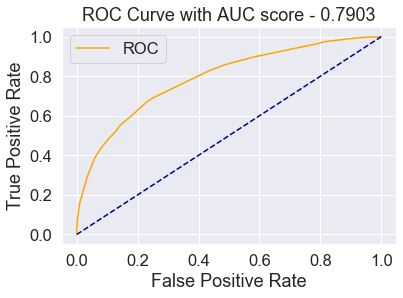

Decision Tree (entropy) score:
Accuracy score 0.80381
Cross val score 0.81929
Auc score 0.79030
Mean squared error - 0.37801
R2 score - 0.23275


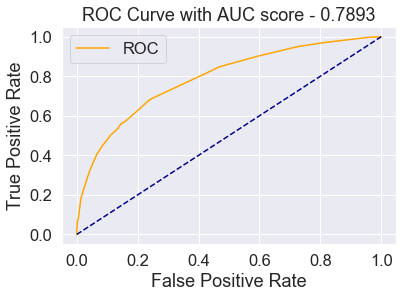

Decision Tree (gini) score:
Accuracy score 0.80051
Cross val score 0.81929
Auc score 0.78935
Mean squared error - 0.37853
R2 score - 0.23064


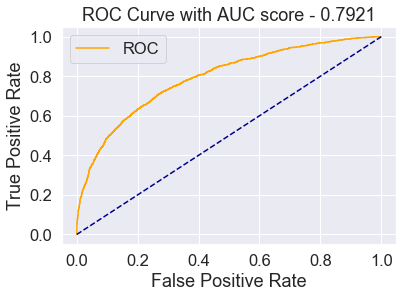

Random Forest (entropy) score:
Accuracy score 0.80201
Cross val score 0.82005
Auc score 0.79211
Mean squared error - 0.37711
R2 score - 0.23638


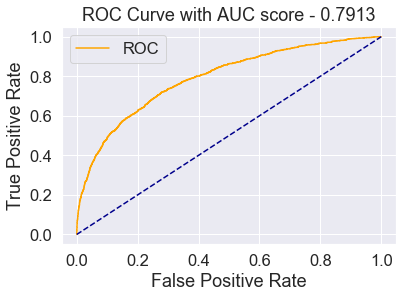

Random Forest (gini) score:
Accuracy score 0.80426
Cross val score 0.81812
Auc score 0.79128
Mean squared error - 0.37716
R2 score - 0.23621


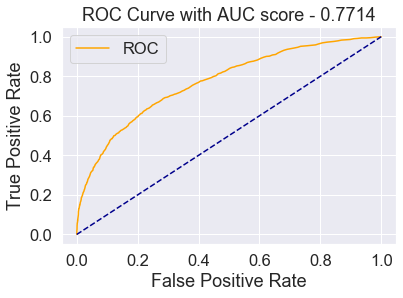

Bagging score:
Accuracy score 0.78986
Cross val score 0.81479
Auc score 0.77145
Mean squared error - 0.38684
R2 score - 0.19648


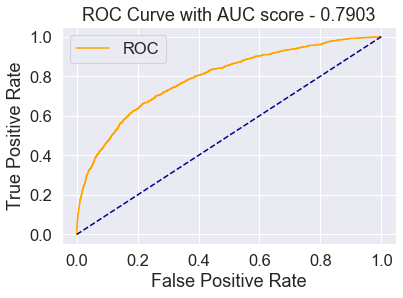

Gradient Boosting score:
Accuracy score 0.80006
Cross val score 0.82251
Auc score 0.79029
Mean squared error - 0.37828
R2 score - 0.23164


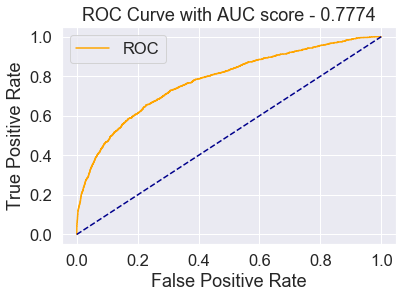

Linear Discriminant Analysis score:
Accuracy score 0.80066
Cross val score 0.81093
Auc score 0.77745
Mean squared error - 0.38058
R2 score - 0.22227


In [26]:
X_train_w, y_train_w = making_X_y_from_df(train)
results('Without balance', X_train_w, y_train_w)

Лучший результат на несбалансированной выборке показал Decision Tree (entropy)
Auc score 0.81151

1    11701
0    11701
Name: TargetBuy, dtype: int64
Oversampling_by_Minority
max_depth = 7


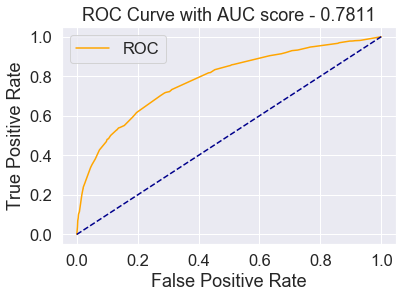

Decision Tree (entropy) score:
Accuracy score 0.75731
Cross val score 0.74744
Auc score 0.78105
Mean squared error - 0.42825
R2 score - 0.01526


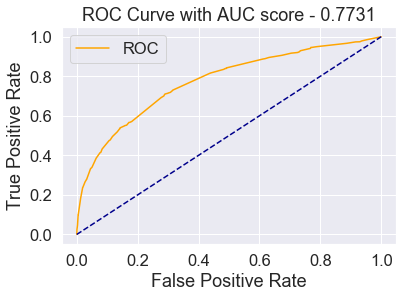

Decision Tree (gini) score:
Accuracy score 0.71486
Cross val score 0.74957
Auc score 0.77312
Mean squared error - 0.42939
R2 score - 0.00998


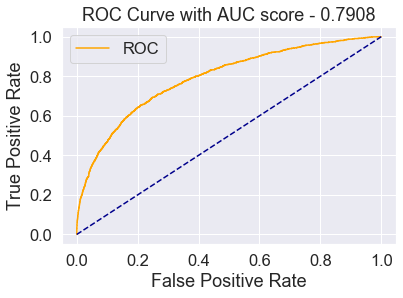

Random Forest (entropy) score:
Accuracy score 0.77156
Cross val score 0.82479
Auc score 0.79083
Mean squared error - 0.40649
R2 score - 0.11276


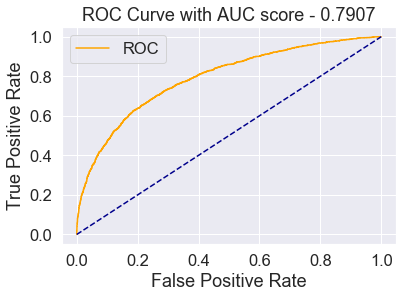

Random Forest (gini) score:
Accuracy score 0.77411
Cross val score 0.83248
Auc score 0.79072
Mean squared error - 0.40446
R2 score - 0.12161


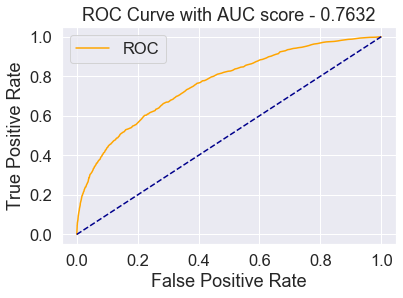

Bagging score:
Accuracy score 0.78131
Cross val score 0.93932
Auc score 0.76322
Mean squared error - 0.39612
R2 score - 0.15749


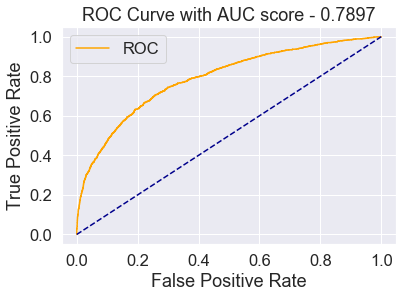

Gradient Boosting score:
Accuracy score 0.75146
Cross val score 0.78419
Auc score 0.78967
Mean squared error - 0.41520
R2 score - 0.07436


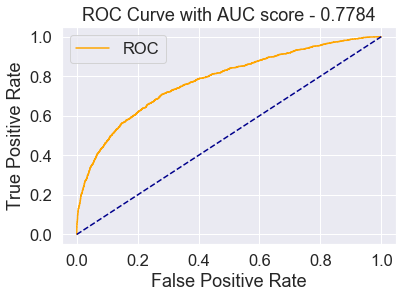

Linear Discriminant Analysis score:
Accuracy score 0.72116
Cross val score 0.73120
Auc score 0.77840
Mean squared error - 0.43012
R2 score - 0.00662


In [27]:
X_train_Minority, y_train_Minority = oversampling_df_by_Minority(train)
results('Oversampling_by_Minority', X_train_Minority, y_train_Minority)

Лучший результат на Random oversampling показал Random Forest
AUC score - 0.82474

Before Oversampling, counts of label '1': 3855
Before Oversampling, counts of label '0': 11701 

After Oversampling, the shape of train_X: (23402, 10)
After Oversampling, the shape of train_y: (23402,) 

After Oversampling, counts of label '1': 11701
After Oversampling, counts of label '0': 11701
Oversampling_by_SMOTE
max_depth = 10


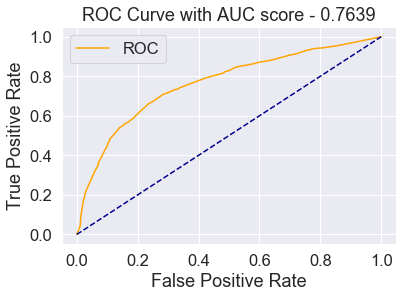

Decision Tree (entropy) score:
Accuracy score 0.78476
Cross val score 0.85256
Auc score 0.76387
Mean squared error - 0.39871
R2 score - 0.14641


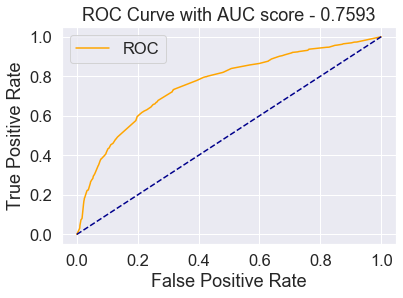

Decision Tree (gini) score:
Accuracy score 0.77741
Cross val score 0.84836
Auc score 0.75926
Mean squared error - 0.40410
R2 score - 0.12318


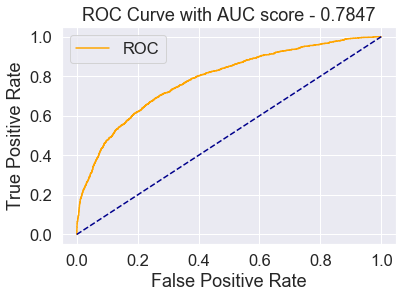

Random Forest (entropy) score:
Accuracy score 0.79316
Cross val score 0.87100
Auc score 0.78473
Mean squared error - 0.38528
R2 score - 0.20296


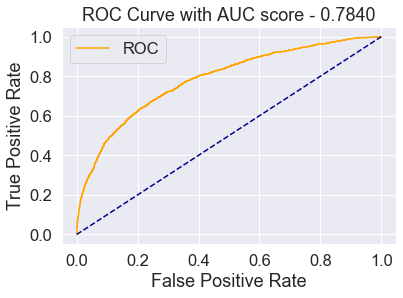

Random Forest (gini) score:
Accuracy score 0.79346
Cross val score 0.87436
Auc score 0.78400
Mean squared error - 0.38527
R2 score - 0.20298


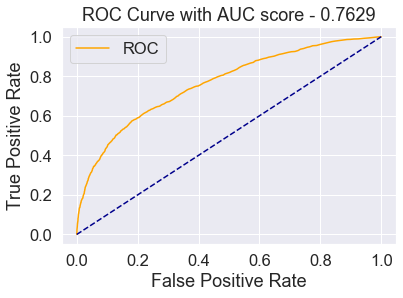

Bagging score:
Accuracy score 0.78716
Cross val score 0.86801
Auc score 0.76287
Mean squared error - 0.39264
R2 score - 0.17220


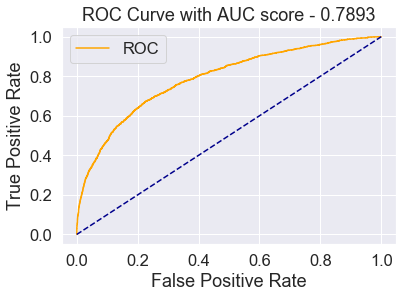

Gradient Boosting score:
Accuracy score 0.79856
Cross val score 0.87826
Auc score 0.78927
Mean squared error - 0.37861
R2 score - 0.23030


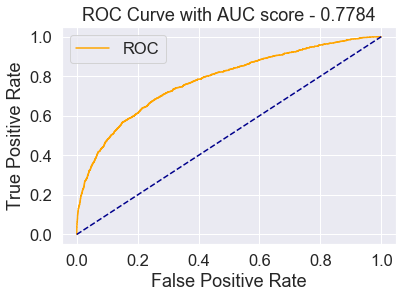

Linear Discriminant Analysis score:
Accuracy score 0.72221
Cross val score 0.73803
Auc score 0.77844
Mean squared error - 0.42978
R2 score - 0.00819


In [28]:
X_train_SMOTE, y_train_SMOTE = oversampling_df_by_SMOTE(train)
results('Oversampling_by_SMOTE', X_train_SMOTE, y_train_SMOTE)

Before Oversampling, counts of label '1': 3855
Before Oversampling, counts of label '0': 11701 

After Oversampling, the shape of train_X: (23746, 10)
After Oversampling, the shape of train_y: (23746,) 

After Oversampling, counts of label '1': 12045
After Oversampling, counts of label '0': 11701
Oversampling_by_ADASYN
max_depth = 12


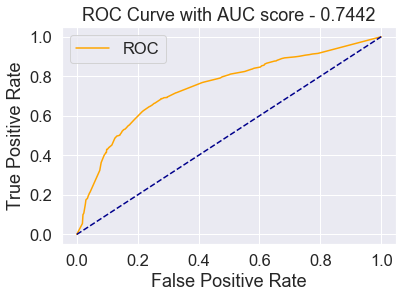

Decision Tree (entropy) score:
Accuracy score 0.77846
Cross val score 0.85383
Auc score 0.74415
Mean squared error - 0.41119
R2 score - 0.09215


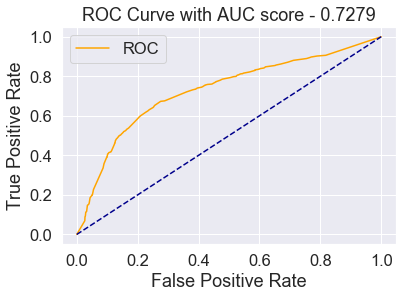

Decision Tree (gini) score:
Accuracy score 0.77426
Cross val score 0.85046
Auc score 0.72789
Mean squared error - 0.41969
R2 score - 0.05423


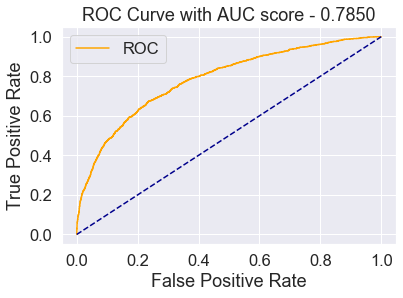

Random Forest (entropy) score:
Accuracy score 0.79346
Cross val score 0.86942
Auc score 0.78504
Mean squared error - 0.38533
R2 score - 0.20272


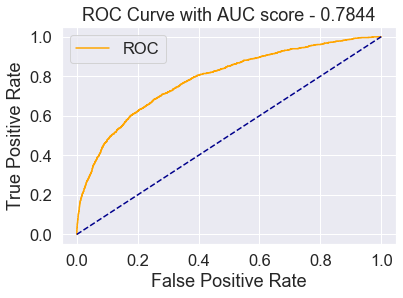

Random Forest (gini) score:
Accuracy score 0.79481
Cross val score 0.87784
Auc score 0.78441
Mean squared error - 0.38513
R2 score - 0.20359


In [ ]:
X_train_ADASYN, y_train_ADASYN = oversampling_df_by_ADASYN(train)
results('Oversampling_by_ADASYN', X_train_ADASYN, y_train_ADASYN)

In [ ]:
X_train_under, y_train_under = undersampling_df(train)
results('Undersampling', X_train_under, y_train_under)

In [ ]:
X_train_NearMiss, y_train_NearMiss = undersampling_df_NearMiss(train)
results('Undersampling_by_NearMiss', X_train_NearMiss, y_train_NearMiss)

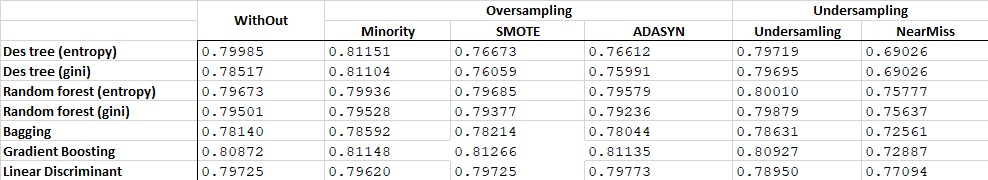

Вывод:
Проведя ислледование данных Organics на поиск наилучшей модели для предсказания того, какие пользователи в будущем 
будут покупать в супермаркете.

Для того, чтобы понимать алгоритмы решений поиска оптимальной модели классификации,
мы, в среде разработки JupyterLab и языка программирования python, разобрали и 
научились использовать необходимые функции. 

Наиболее значиными критериями оказались поля: уровень дохода, возраст и пол покупателя

Проведя анализ оценок, получившихся в результате построения моделей классификации, 
таких как решающее дерево, случайный лес с критериями энтропии и джини, бэггинг, градиент бустинг и линейного дискриминанта на разных методах балансировки можно сделать вывод, что наилучшими являются
методы градиентного бустинга и случайного леса. При этом лучшие результаты были получены на балансировках Мinority.

Таким образом мы исследовали не только модели, но и различные методы балансировки.